This notebook contains advanced model for personality prediction 
using MBTI dataset. 

The Myers Briggs Type Indicator (or MBTI for short) is a personality type system that divides everyone into 16 distinct personality types across 4 axis:
* Introversion (I) – Extroversion (E)
* Intuition (N) – Sensing (S)
* Thinking (T) – Feeling (F)
* Judging (J) – Perceiving (P)

In the dataset, there are 8600 rows of data. Each row contains a person's MBTI personality class and the last 50 things that he/she posted in PersonalityCafe Forum. 



In [2]:
# import libraries 
from os.path import join
import matplotlib.pyplot as plt


import json 
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
seed = 123
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, GRU, SimpleRNN
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing import text
from keras.optimizers import Adam
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import StratifiedKFold
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from keras.utils import to_categorical
from keras.preprocessing import text
from keras.preprocessing import sequence
from keras import layers
import zipfile


In [3]:
# Define constants 
data_folder = ""
raw_data_file = "mbti_1.csv"
punc_data_file = join(data_folder,"preprocessed_data_punc.json")
links_data_file = join(data_folder,"preprocessed_data_links.json")
letter_data_file = join(data_folder,"preprocessed_data_letters.json")
type_data_file = join(data_folder,"preprocessed_data_type.json")
prep_data_file = join(data_folder,"preprocessed_data_all.json")
none_data_file = join(data_folder,"preprocessed_data_none.json")

n_splits = 5 # number of splits for cross-validation
shuffle_flag = True 

scoring = {'acc': 'accuracy',
           'neg_log_loss': 'neg_log_loss',
           'f1_micro': 'f1_micro'}

In [4]:
# define functions 
def read_dataset(filepath):
    with open(filepath) as fp:
        return json.load(fp)

plt.style.use('ggplot')

def plot_history(history):
    acc = None 
    val_acc = None 
    loss = None 
    val_loss = None 
    if "accuracy" in history.history.keys():
        acc = history.history['accuracy']
    elif "acc" in history.history.keys():
        acc = history.history['acc']
    if "val_accuracy" in history.history.keys():  
        val_acc = history.history['val_accuracy']
    if 'loss' in history.history.keys():
        loss = history.history['loss']
    if 'val_loss' in history.history.keys():
        val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    title = ""
    if acc:
        plt.plot(x, acc, 'b', label='Training acc')
        title += "Training" 
    if val_acc: 
        plt.plot(x, val_acc, 'r', label='Validation acc')
        title += " and validation"
    title += " accuracy"
    plt.title(title)
    plt.legend()
    plt.subplot(1, 2, 2)
    title = ""
    if loss: 
        plt.plot(x, loss, 'b', label='Training loss')
        title += "Training"
    if val_loss: 
        plt.plot(x, val_loss, 'r', label='Validation loss')
        title += " and validation"
    title += " loss"
    plt.title(title)
    plt.legend()


## Prepare Data

In [30]:
# define constant 
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 1000
# This is fixed.
EMBEDDING_DIM = 100
padding_place = 'post'
DROPOUT = 0.6
LEARNING_RATE = 0.001
max_features_dim = 5000
input_dim = 5000
output_dim = 16 
hidden_dim = 8
n_splits = 5 
shuffle_flag = True 

In [22]:
def prepare_data(data_file, 
                 max_sent_len=100, 
                 json_flag=False,
                 padding_place='post',
                 max_nb_words = 50000,
                 test_size=0.2):
    """ for a given datafile reads the content and returns 
      posts and labels 
      @data_file: string, the path of the file 
      @json_flag: bool, True if given file is in json format
      @max_features: int, number of features in tf-idf
      Returns 
      @X_train_cnt: tf-idf vectors of training posts  
      @X_tes_cnt: tf-idf vectors of test posts
      @y_train: int, train labels 
      @y_test: int, test labels
    """
    if json_flag:
        dataset = read_dataset(data_file)
        posts = list(dataset['posts'])
        labels = list(dataset['types'])
    else:
        dataset = pd.read_csv(data_file)
        posts = list(dataset['posts'].values)
        labels = list(dataset['type'].values)
    print("The number of data %d " %(len(posts)))
    print("Example from dataset")
    print(posts[0][0:50]) 
    print("For type %s" %(labels[0]))
    posts = [p.lower() for p in posts]
    #return posts, labels

    # get the vocabulary 
    vocabulary = []
    for p in posts:
        for word in p.split():
            vocabulary.append(word)
        if len(p.split())> max_sent_len:
            max_sent_len = len(p.split())  
    vocabulary = set(vocabulary)
    print("The vocabulary size is  %d " %(len(vocabulary)))
    print("The maximum post length is %d " %(max_sent_len))

    tokenizer = text.Tokenizer(num_words=max_nb_words,
                               lower=True,
                               split=" ")
    tokenizer.fit_on_texts(posts)
    word_index = tokenizer.word_index
    print('Found %s unique tokens.' % len(word_index))

    tokenized_X = tokenizer.texts_to_sequences(posts)
    print("Example from tokenized X ")
    print(tokenized_X[0][0:50])

    padded_X = sequence.pad_sequences(tokenized_X,
                                      maxlen=max_sent_len, 
                                      padding=padding_place)
    print('Shape of data tensor after tokenization and padding:', padded_X.shape)

    vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index
    print("Vocabulary Size %d " %(vocab_size))

    # train-test split for deep learning methods

    y_binarized_labels = to_categorical(labels)

    X_train_pad, X_test_pad, y_train_pad, y_test_pad = train_test_split(padded_X,
                                                                        y_binarized_labels, 
                                                                        test_size=test_size, 
                                                                        random_state=seed)
    print("Number of examples in train set %d " %(len(X_train_pad)))
    print("The shape of X training tensor (%d,%d) " %(X_train_pad.shape))
    print("The shape of y training tensor (%d,%d) " %(y_train_pad.shape))

    print("Number of examples in test set %d " %(len(X_test_pad)))
    print("The shape of X test tensor (%d,%d)" %(X_test_pad.shape))
    return X_train_pad, X_test_pad, y_train_pad, y_test_pad , vocab_size, tokenizer

In [7]:
def prepare_data_tfidf(data_file, max_features= 5000, json_flag=False):
    """ for a given datafile reads the content and returns 
      posts and labels 
      @data_file: string, the path of the file 
      @json_flag: bool, True if given file is in json format
      @max_features: int, number of features in tf-idf
      Returns 
      @X_train_cnt: tf-idf vectors of training posts  
      @X_tes_cnt: tf-idf vectors of test posts
      @y_train: int, train labels 
      @y_test: int, test labels
    """
    if json_flag:
        dataset = read_dataset(data_file)
        posts = list(dataset['posts'])
        labels = list(dataset['types'])
    else:
        dataset = pd.read_csv(data_file)
        posts = list(dataset['posts'].values)
        labels = list(dataset['type'].values)
    print("The number of data %d " %(len(posts)))
    print("Example from dataset")
    print(posts[0][0:50]) 
    print("For type %s" %(labels[0]))
    posts = [p.lower() for p in posts]
    #return posts, labels 

    # train-test split 
    X = np.array(posts)
    y = np.array(labels)
    X_train, X_test, y_train, y_test = train_test_split(posts, labels, 
                                                    test_size=0.2, 
                                                    random_state=seed)
    print("Number of examples in train set %d " %(len(X_train)))
    print("Number of examples in test set %d " %(len(X_test)))

    # create a matrix of numbers to represent posts
    tfidf2 = CountVectorizer(ngram_range=(1, 1), 
                         stop_words='english',
                         lowercase = False, 
                         max_features = max_features)

    X_train_cnt = tfidf2.fit_transform(X_train)
    X_test_cnt = tfidf2.transform(X_test)

    # binarizer 16 classes 
    y_binary = to_categorical(y_train)
    y_test_binary = to_categorical(y_test)  
    return X_train_cnt, X_test_cnt, y_binary, y_test_binary

In [31]:
X_train,X_test,y_train,y_test,vocab_size,tokenizer =  prepare_data(letter_data_file,json_flag=True)

The number of data 8675 
Example from dataset
  http   www youtube com watch v qsxhcwe krw http 
For type 8
The vocabulary size is  121112 
The maximum post length is 956 
Found 121112 unique tokens.
Example from tokenized X 
[11, 30, 31, 12, 26, 27, 11, 395, 451, 12, 451, 9101, 151, 84, 56, 293, 11, 30, 31, 12, 26, 27, 11809, 227, 651, 11810, 552, 1651, 243, 11, 30, 31, 12, 26, 27, 5690, 35, 1318, 143, 35, 11, 30, 31, 12, 26, 27, 11, 30, 31, 12]
Shape of data tensor after tokenization and padding: (8675, 956)
Vocabulary Size 121113 
Number of examples in train set 6940 
The shape of X training tensor (6940,956) 
The shape of y training tensor (6940,16) 
Number of examples in test set 1735 
The shape of X test tensor (1735,956)


In [9]:
X_train_cnt,X_test_cnt,y_train_cnt,y_test_cnt =  prepare_data_tfidf(letter_data_file,
                                                                    max_features_dim,
                                                                    True)

The number of data 8675 
Example from dataset
  http   www youtube com watch v qsxhcwe krw http 
For type 8
Number of examples in train set 6940 
Number of examples in test set 1735 


## Using TfIdf as features for deep learning methods


In [10]:
# define baseline model
def baseline_model(input_dim,output_dim,hidden_dim):
	# create model
	model = Sequential()
	model.add(Dense(hidden_dim, input_dim=input_dim, activation='relu'))
	model.add(Dense(output_dim, activation='softmax'))
	# Compile model
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

In [12]:
model = baseline_model(input_dim,output_dim,hidden_dim)

history = model.fit(X_train_cnt, y_train_cnt,
                    epochs=10,
                    verbose=False,
                    batch_size=10,
                    validation_split=0.1)
loss, accuracy = model.evaluate(X_train_cnt, y_train_cnt, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test_cnt, y_test_cnt, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9491
Testing Accuracy:  0.5378


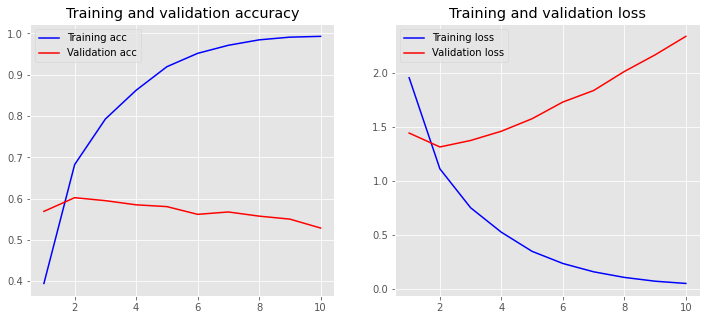

In [13]:
plot_history(history) 

## Using Word Embeddings  

In [14]:
def simple_embedding_model(input_dim, hidden_dim, input_length, output_dim):
  model = Sequential()
  model.add(layers.Embedding(input_dim=input_dim, 
                            output_dim=hidden_dim, 
                            input_length=input_length))
  model.add(layers.Flatten())
  model.add(layers.Dense(hidden_dim, activation='relu'))
  model.add(Dense(output_dim, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  #model.summary()
  return model 


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 6246 samples, validate on 694 samples
Epoch 1/5
6246/6246 [==============================] - 2s 387us/step - loss: 2.6370 - accuracy: 0.1335 - val_loss: 2.5153 - val_accuracy: 0.1571
Epoch 2/5
6246/6246 [==============================] - 2s 374us/step - loss: 2.3779 - accuracy: 0.2269 - val_loss: 2.3078 - val_accuracy: 0.2695
Epoch 3/5
6246/6246 [==============================] - 2s 361us/step - loss: 2.0806 - accuracy: 0.3180 - val_loss: 2.1032 - val_accuracy: 0.2997
Epoch 4/5
6246/6246 [==============================] - 2s 368us/step - loss: 1.7205 - accuracy: 0.4814 - val_loss: 1.9997 - val_accuracy: 0.3156
Epoch 5/5
6246/6246 [==============================] - 2s 362us/step - loss: 1.2821 - accuracy: 0.6084 - val_loss: 2.0002 - val_accuracy: 0.3473
Training Accuracy: 0.6677
Testing Accuracy:  0.3464


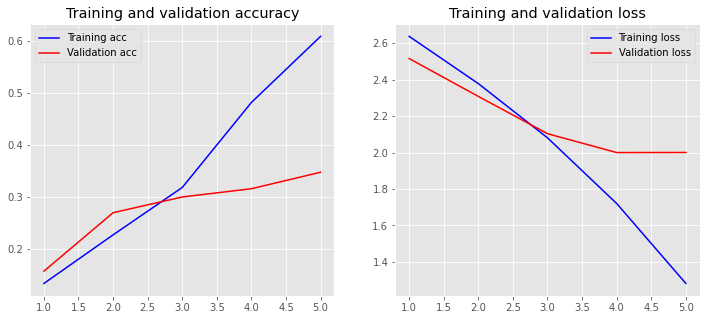

In [15]:
model = simple_embedding_model(input_dim=vocab_size,
                               hidden_dim=hidden_dim,
                               input_length = X_train.shape[1],
                               output_dim = 16)

history = model.fit(X_train, y_train,
                    epochs=5,
                    verbose=True,
                    batch_size=50,
                    validation_split = 0.1)

loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [18]:
def lstm_model(input_dim,
               hidden_dim, 
               input_length,
               output_dim, 
               dropout =0.2,
               learning_rate = 0.2):
  model = Sequential()
  model.add(Embedding(input_dim,
                      hidden_dim, 
                      input_length=input_length, 
                      mask_zero=True, 
                      trainable=True))
  model.add(LSTM(hidden_dim,
                 dropout=dropout, 
                 recurrent_dropout=dropout, 
                 activation='sigmoid',
                 kernel_initializer='zeros'))
  model.add(Dense(output_dim, activation='softmax'))
  optimizer = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
  model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  return model 
  

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 6246 samples, validate on 694 samples
Epoch 1/20
6246/6246 [==============================] - 80s 13ms/step - loss: 2.3362 - accuracy: 0.1945 - val_loss: 2.2983 - val_accuracy: 0.1888
Epoch 2/20
6246/6246 [==============================] - 79s 13ms/step - loss: 2.3156 - accuracy: 0.1894 - val_loss: 2.3415 - val_accuracy: 0.1859
Epoch 3/20
6246/6246 [==============================] - 82s 13ms/step - loss: 2.3290 - accuracy: 0.1897 - val_loss: 2.3259 - val_accuracy: 0.2118
Epoch 4/20
6246/6246 [==============================] - 79s 13ms/step - loss: 2.3065 - accuracy: 0.2027 - val_loss: 2.3987 - val_accuracy: 0.1700
Epoch 5/20
6246/6246 [==============================] - 79s 13ms/step - loss: 2.2813 - accuracy: 0.2118 - val_loss: 2.3969 - val_accuracy: 0.1873
Epoch 6/20
6246/6246 [==============================] - 79s 13ms/step - loss: 2.2829 - accuracy: 0.2166 - val_loss: 2.3850 - val_accuracy: 0.2089
Epoch 7/20
6246/6246 [==============================] - 78s 13ms/step - loss:

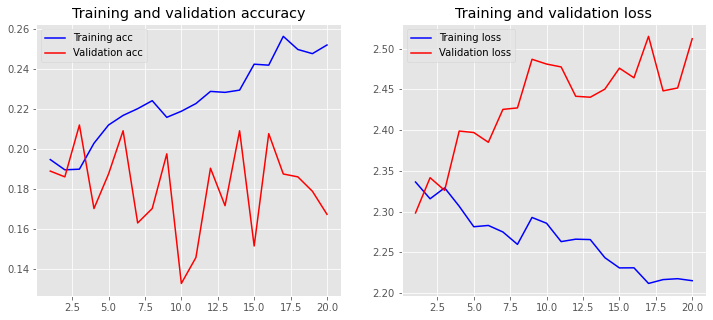

In [19]:
model = lstm_model(input_dim=vocab_size,
                   hidden_dim=hidden_dim,
                   input_length = X_train.shape[1],
                   output_dim = 16)

history = model.fit(X_train, y_train,
                    epochs=20,
                    verbose=True,
                    batch_size=50,
                    validation_split=0.1)

loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

## Using Pre-trained word embeddings 


In [21]:
# get the embeddings 
! wget http://nlp.stanford.edu/data/glove.6B.zip
folder = 'glove_folder'
with zipfile.ZipFile("glove.6B.zip","r") as zip_ref:
    zip_ref.extractall(folder)

--2020-06-22 17:41:35--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-06-22 17:41:35--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-06-22 17:41:36--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [32]:
# from https://realpython.com/python-keras-text-classification/ 
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [33]:
embedding_dim = 50
embedding_matrix = create_embedding_matrix(
     'glove_folder/glove.6B.50d.txt',
     tokenizer.word_index, embedding_dim)

In [36]:
def lstm_model_embedding(input_dim,
              hidden_dim,
              embedding_matrix, 
              input_length,
              output_dim, 
              dropout = 0.2,
              learning_rate=0.01):
  model = Sequential()
  model.add(Embedding(input_dim,
                      hidden_dim, 
                      weights=[embedding_matrix], 
                      input_length=input_length,
                      mask_zero=True, 
                      trainable=False))
  model.add(LSTM(hidden_dim, 
                dropout=dropout, 
                recurrent_dropout=dropout, 
                activation='sigmoid',
                kernel_initializer='zeros'))
  model.add(Dense(output_dim, activation='softmax'))
  optimizer = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
  model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  return model

In [41]:
hidden_dim = 50 

model = lstm_model_embedding(vocab_size,
                  hidden_dim,
                  embedding_matrix,
                  X_train.shape[1],
                  16)

history = model.fit(X_train, y_train,
                    epochs=20,
                    verbose=True,
                    batch_size=50,
                    validation_split=0.1)

loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))


Train on 6246 samples, validate on 694 samples
Epoch 1/20
6246/6246 [==============================] - 103s 16ms/step - loss: 2.3216 - accuracy: 0.1844 - val_loss: 2.2917 - val_accuracy: 0.2147
Epoch 2/20
6246/6246 [==============================] - 101s 16ms/step - loss: 2.2908 - accuracy: 0.2064 - val_loss: 2.2825 - val_accuracy: 0.2118
Epoch 3/20
6246/6246 [==============================] - 101s 16ms/step - loss: 2.2736 - accuracy: 0.2109 - val_loss: 2.2645 - val_accuracy: 0.2507
Epoch 4/20
6246/6246 [==============================] - 101s 16ms/step - loss: 2.2123 - accuracy: 0.2638 - val_loss: 2.2259 - val_accuracy: 0.2651
Epoch 5/20
6246/6246 [==============================] - 101s 16ms/step - loss: 2.1729 - accuracy: 0.2803 - val_loss: 2.2181 - val_accuracy: 0.2522
Epoch 6/20
6246/6246 [==============================] - 101s 16ms/step - loss: 2.1505 - accuracy: 0.2895 - val_loss: 2.1943 - val_accuracy: 0.2695
Epoch 7/20
6246/6246 [==============================] - 103s 17ms/step 

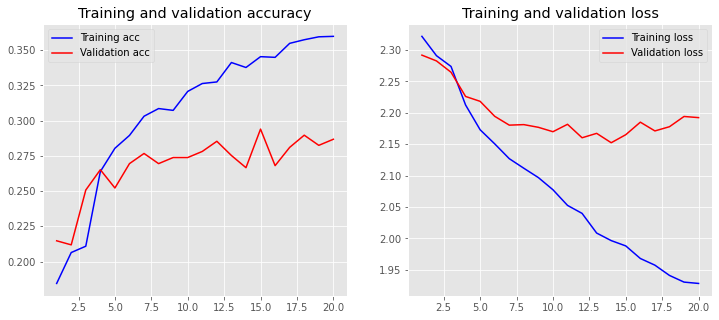

In [42]:
plot_history(history)

# Ablation study for the best model 

In [46]:
data_files = {"all":prep_data_file,
              "punc":punc_data_file,
              "links":links_data_file,
              "letters":letter_data_file,
              "type":type_data_file,
             "none":none_data_file}
for k,v in data_files.items():
    print("Modelling for %s " %(k))
    X_train_cnt,X_test_cnt,y_train_cnt,y_test_cnt =  prepare_data_tfidf(data_files[k],
                                                                    max_features_dim,
                                                                    True)
    model = baseline_model(input_dim,output_dim,hidden_dim)

    history = model.fit(X_train_cnt, y_train_cnt,
                    epochs=10,
                    verbose=False,
                    batch_size=10,
                    validation_split=0.1)
    loss, accuracy = model.evaluate(X_train_cnt, y_train_cnt, verbose=False)
    print("Training Accuracy: {:.4f}".format(accuracy))
    loss, accuracy = model.evaluate(X_test_cnt, y_test_cnt, verbose=False)
    print("Testing Accuracy:  {:.4f}".format(accuracy))
    #plot_history(history)
   

Modelling for all 
The number of data 8675 
Example from dataset
  link link type type moment link sportscenter top
For type 8
Number of examples in train set 6940 
Number of examples in test set 1735 
Training Accuracy: 0.9375
Testing Accuracy:  0.3597
Modelling for punc 
The number of data 8675 
Example from dataset
 'http://www.youtube.com/watch?v=qsxhcwe3krw http:
For type 8
Number of examples in train set 6940 
Number of examples in test set 1735 
Training Accuracy: 0.9476
Testing Accuracy:  0.5885
Modelling for links 
The number of data 8675 
Example from dataset
 'link link enfp intj moment  link  sportscenter t
For type 8
Number of examples in train set 6940 
Number of examples in test set 1735 
Training Accuracy: 0.9638
Testing Accuracy:  0.6173
Modelling for letters 
The number of data 8675 
Example from dataset
  http   www youtube com watch v qsxhcwe krw http 
For type 8
Number of examples in train set 6940 
Number of examples in test set 1735 
Training Accuracy: 0.9611
Tes

In [47]:
data_files = {"all":prep_data_file,
              "punc":punc_data_file,
              "links":links_data_file,
              "letters":letter_data_file,
              "type":type_data_file,
             "none":none_data_file}
for k,v in data_files.items():
    print("Modelling for %s " %(k))
    X_train,X_test,y_train,y_test,vocab_size,tokenizer =  prepare_data(data_files[k],json_flag=True)
    
    model = simple_embedding_model(input_dim=vocab_size,
                               hidden_dim=hidden_dim,
                               input_length = X_train.shape[1],
                               output_dim = 16)

    history = model.fit(X_train, y_train,
                    epochs=5,
                    verbose=True,
                    batch_size=50,
                    validation_split = 0.1)

    loss, accuracy = model.evaluate(X_train, y_train, verbose=False)  
    print("Training Accuracy: {:.4f}".format(accuracy))
    loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
    print("Testing Accuracy:  {:.4f}".format(accuracy))
    # plot_history(history)

Modelling for all 
The number of data 8675 
Example from dataset
  link link type type moment link sportscenter top
For type 8
The vocabulary size is  88643 
The maximum post length is 921 
Found 88643 unique tokens.
Example from tokenized X 
[12, 12, 1, 1, 267, 12, 45827, 521, 1590, 223, 12, 5581, 30, 1264, 131, 30, 12, 12, 1822, 237, 103, 552, 131, 10842, 132, 9, 1, 18, 432, 867, 5267, 1833, 339, 50, 627, 1138, 12, 334, 1, 160, 298, 6148, 668, 71, 3508, 10, 115, 267, 1304, 64]
Shape of data tensor after tokenization and padding: (8675, 921)
Vocabulary Size 88644 
Number of examples in train set 6940 
The shape of X training tensor (6940,921) 
The shape of y training tensor (6940,16) 
Number of examples in test set 1735 
The shape of X test tensor (1735,921)


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 6246 samples, validate on 694 samples
Epoch 1/5
6246/6246 [==============================] - 12s 2ms/step - loss: 2.3284 - accuracy: 0.1956 - val_loss: 2.2675 - val_accuracy: 0.2291
Epoch 2/5
6246/6246 [==============================] - 12s 2ms/step - loss: 1.5596 - accuracy: 0.5764 - val_loss: 2.2737 - val_accuracy: 0.2464
Epoch 3/5
6246/6246 [==============================] - 12s 2ms/step - loss: 0.2191 - accuracy: 0.9673 - val_loss: 2.4980 - val_accuracy: 0.2392
Epoch 4/5
6246/6246 [==============================] - 12s 2ms/step - loss: 0.0141 - accuracy: 0.9994 - val_loss: 2.5476 - val_accuracy: 0.2421
Epoch 5/5
6246/6246 [==============================] - 12s 2ms/step - loss: 0.0066 - accuracy: 0.9997 - val_loss: 2.6253 - val_accuracy: 0.2363
Training Accuracy: 0.9233
Testing Accuracy:  0.2634
Modelling for punc 
The number of data 8675 
Example from dataset
 'http://www.youtube.com/watch?v=qsxhcwe3krw http:
For type 8
The vocabulary size is  351635 
The maximum post leng